In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()

In [2]:
# Load the data
file_path = 'outputs/corrected_daily_energy_met_MU.csv'
data = pd.read_csv(file_path)

In [3]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [4]:
# Define a function to perform STL decomposition and return the result
def perform_stl(column, period):
	stl = STL(data[column], seasonal=7, period=period)
	result = stl.fit()
	return result

In [6]:
state_1 = 'Kerala'
state_2 = 'Uttar Pradesh'

# Perform STL decomposition for 'Total', state_1, and state_2
total_result = perform_stl('Total', 365)
state1_result = perform_stl(state_1, 365)
state2_result = perform_stl(state_2, 365)

In [8]:
# Calculate variance-corrected values
def variance_corrected(data, trend, window, ref_year):
	variance_prev_12_months = data.rolling(window=window).std()
	variance_2023 = data.loc[data.index.year == ref_year].std()
	corrected_values = (data - trend) / variance_prev_12_months * variance_2023
	return corrected_values

In [9]:
# Calculate variance-corrected values for Total, Kerala, and Uttar Pradesh
window = 365  # 12 months window
ref_year = 2023

total_corrected = variance_corrected(data['Total'], total_result.trend, window, ref_year)
state1_corrected = variance_corrected(data[state_1], state1_result.trend, window, ref_year)
state2_corrected = variance_corrected(data[state_2], state2_result.trend, window, ref_year)

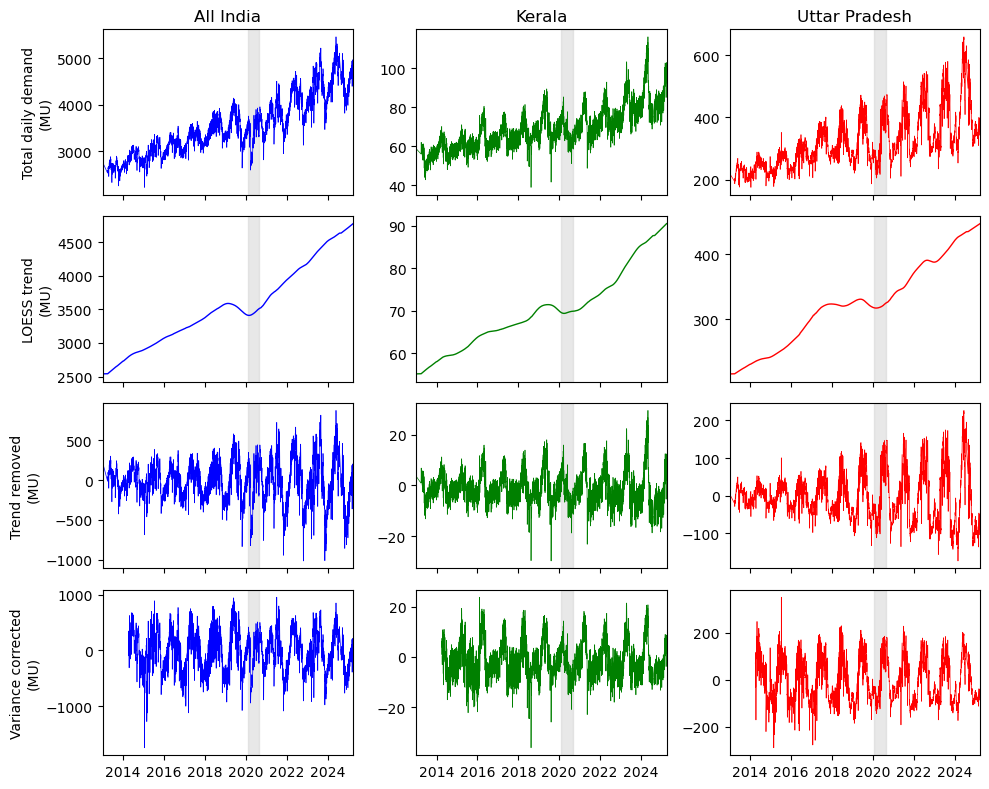

In [11]:
# Create a 4x3 subplot
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharex=True)


# Plot original data
axes[0, 0].plot(data.index, data['Total'], color='blue', linewidth=0.5)
axes[0, 1].plot(data.index, data[state_1], color='green', linewidth=0.5)
axes[0, 2].plot(data.index, data[state_2], color='red', linewidth=0.5)

# Plot trend
axes[1, 0].plot(data.index, total_result.trend, color='blue', linewidth=1)
axes[1, 1].plot(data.index, state1_result.trend, color='green', linewidth=1)
axes[1, 2].plot(data.index, state2_result.trend, color='red', linewidth=1)

# Plot original minus trend
axes[2, 0].plot(data.index, data['Total'] - total_result.trend, color='blue', linewidth=0.5)
axes[2, 1].plot(data.index, data[state_1] - state1_result.trend, color='green', linewidth=0.5)
axes[2, 2].plot(data.index, data[state_2] - state2_result.trend, color='red', linewidth=0.5)

# Plot variance-corrected values
axes[3, 0].plot(data.index, total_corrected, color='blue', linewidth=0.5)
axes[3, 1].plot(data.index, state1_corrected, color='green', linewidth=0.5)
axes[3, 2].plot(data.index, state2_corrected, color='red', linewidth=0.5)

# Set titles for each column
axes[0, 0].set_title('All India')
axes[0, 1].set_title(state_1)
axes[0, 2].set_title(state_2)

# Set y-axis labels for the rows
axes[0, 0].set_ylabel("Total daily demand\n(MU)")
axes[1, 0].set_ylabel("LOESS trend\n(MU)")
axes[2, 0].set_ylabel("Trend removed\n(MU)")
axes[3, 0].set_ylabel("Variance corrected\n(MU)")

# Set the x-axis limits to the data range
start_date = data.index.min()
end_date = data.index.max()

for ax in axes.flat:
	ax.set_xlim([start_date, end_date])

# Add a light grey vertical band between Feb 1 2020 and Aug 31 2020
band_start = pd.to_datetime('2020-02-01')
band_end = pd.to_datetime('2020-08-31')

for ax in axes.flat:
	ax.axvspan(band_start, band_end, color='lightgrey', alpha=0.5)

plt.tight_layout()
plt.show()
